# Weather-Aware Bike Demand - Exploratory Data Analysis

This notebook performs exploratory data analysis on the NYC bike-share and weather data using Polars for efficient data processing.

## Table of Contents
1. Data Loading
2. Data Quality Check
3. Univariate Analysis
4. Temporal Patterns
5. Weather Impact Analysis
6. Outlier Detection


In [1]:
# Import libraries
import warnings

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

import duckdb

warnings.filterwarnings("ignore")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

Load data from DuckDB warehouse using Polars for efficient processing.


In [2]:
# Connect to DuckDB and load data
con = duckdb.connect("../duckdb/warehouse.duckdb", read_only=True)

# Load demand data
demand_query = "SELECT * FROM main_marts.mart_demand_daily ORDER BY ride_date"
df_demand = pl.from_pandas(con.execute(demand_query).df())

# Load weather effect data if available
try:
    weather_query = "SELECT * FROM main_marts.mart_weather_effect ORDER BY date"
    df_weather = pl.from_pandas(con.execute(weather_query).df())
    has_weather = True
    print(f"✓ Loaded demand data: {df_demand.shape[0]} days")
    print(f"✓ Loaded weather data: {df_weather.shape[0]} days")
except Exception as e:
    has_weather = False
    print(f"✓ Loaded demand data: {df_demand.shape[0]} days")
    print(f"⚠ Weather data not available: {e}")

✓ Loaded demand data: 63 days
✓ Loaded weather data: 63 days


## 2. Data Quality Check

Inspect schema, missing values, and basic statistics.


In [3]:
# Display schema and summary
print("=" * 60)
print("DEMAND DATA SCHEMA")
print("=" * 60)
print(df_demand.describe())
print("\nFirst few rows:")
print(df_demand.head())

# Check for missing values
null_counts = df_demand.null_count()
print("\n" + "=" * 60)
print("NULL VALUE COUNTS")
print("=" * 60)
print(null_counts)

DEMAND DATA SCHEMA
shape: (9, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ ride_date ┆ trips_tot ┆ avg_durat ┆ … ┆ total_end ┆ day_of_we ┆ day_of_we ┆ day_type │
│ ---       ┆ ---       ┆ al        ┆ ion_mins  ┆   ┆ _stations ┆ ek        ┆ ek_num    ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ str       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 63        ┆ 63.0      ┆ 63.0      ┆ … ┆ 63.0      ┆ 63        ┆ 63.0      ┆ 63       │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0         ┆ 0.0       ┆ 0        │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 2024-05-3 ┆ 141478.66 ┆ 23.391609 ┆ … ┆ 398

## 3. Univariate Analysis

Analyze distributions of key metrics.


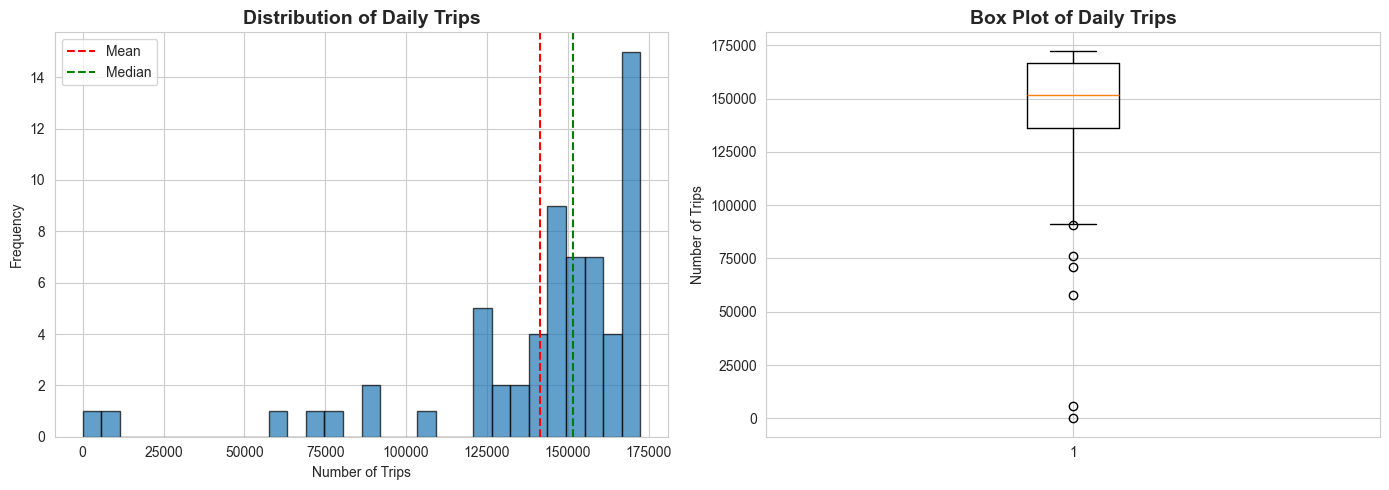

Mean daily trips: 141479
Median daily trips: 151569
Std dev: 35894
Min: 9.0, Max: 172442.0


In [4]:
# Distribution of daily trips
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_demand["trips_total"], bins=30, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribution of Daily Trips", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Number of Trips")
axes[0].set_ylabel("Frequency")
axes[0].axvline(df_demand["trips_total"].mean(), color="red", linestyle="--", label="Mean")
axes[0].axvline(df_demand["trips_total"].median(), color="green", linestyle="--", label="Median")
axes[0].legend()

# Box plot
axes[1].boxplot(df_demand["trips_total"], vert=True)
axes[1].set_title("Box Plot of Daily Trips", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Number of Trips")

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean daily trips: {df_demand['trips_total'].mean():.0f}")
print(f"Median daily trips: {df_demand['trips_total'].median():.0f}")
print(f"Std dev: {df_demand['trips_total'].std():.0f}")
print(f"Min: {df_demand['trips_total'].min()}, Max: {df_demand['trips_total'].max()}")

## 4. Temporal Patterns

Analyze time-based patterns in bike demand.


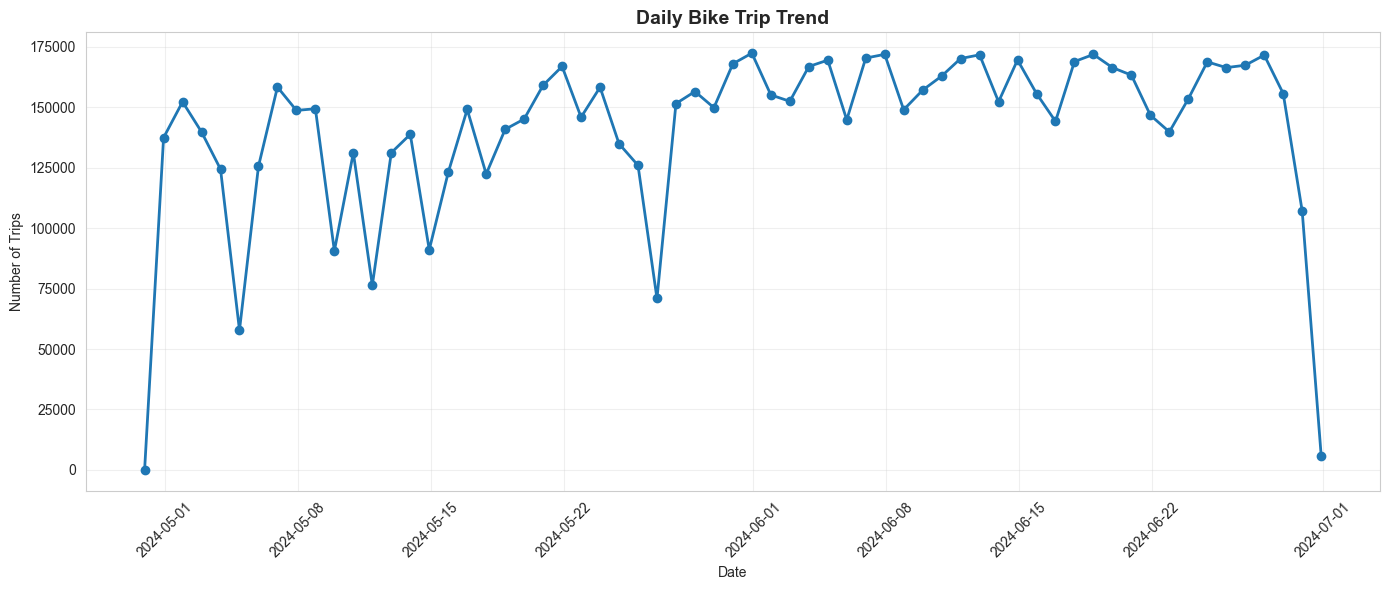


WEEKDAY VS WEEKEND COMPARISON
shape: (2, 3)
┌──────────┬───────────────┬──────────────┐
│ day_type ┆ avg_trips     ┆ std_trips    │
│ ---      ┆ ---           ┆ ---          │
│ str      ┆ f64           ┆ f64          │
╞══════════╪═══════════════╪══════════════╡
│ Weekday  ┆ 143904.155556 ┆ 37776.331166 │
│ Weekend  ┆ 135414.944444 ┆ 30836.146741 │
└──────────┴───────────────┴──────────────┘


In [5]:
# Daily trend
plt.figure(figsize=(14, 6))
plt.plot(df_demand["ride_date"], df_demand["trips_total"], marker="o", linewidth=2)
plt.title("Daily Bike Trip Trend", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Weekday vs Weekend comparison
weekday_stats = df_demand.group_by("day_type").agg(
    [
        pl.col("trips_total").mean().alias("avg_trips"),
        pl.col("trips_total").std().alias("std_trips"),
    ]
)
print("\n" + "=" * 60)
print("WEEKDAY VS WEEKEND COMPARISON")
print("=" * 60)
print(weekday_stats)

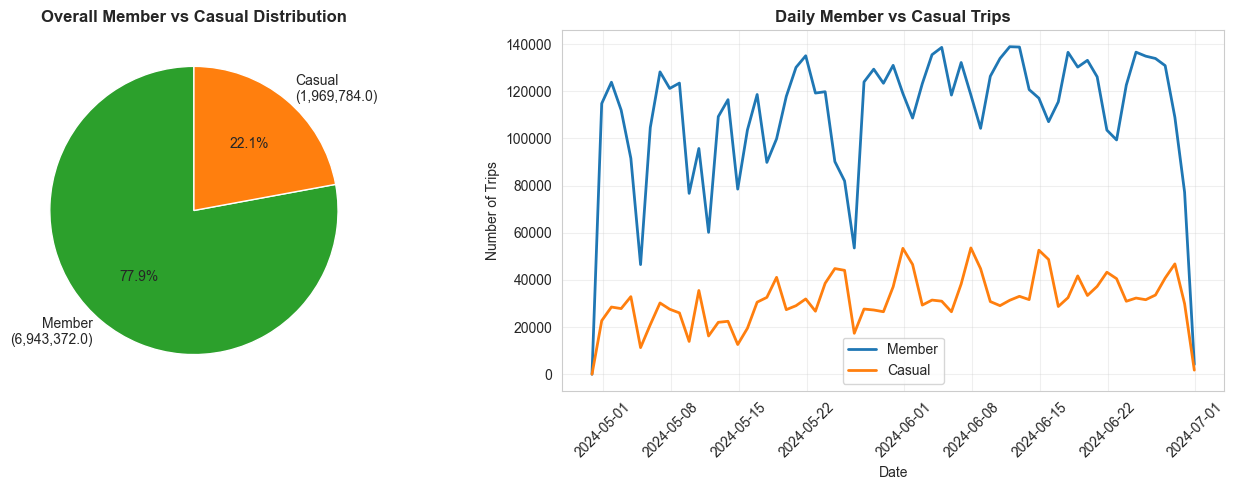

In [6]:
# Member vs Casual split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
member_total = df_demand["member_trips"].sum()
casual_total = df_demand["casual_trips"].sum()
sizes = [member_total, casual_total]
labels = [f"Member\n({member_total:,})", f"Casual\n({casual_total:,})"]
colors = ["#2ca02c", "#ff7f0e"]
axes[0].pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Overall Member vs Casual Distribution", fontweight="bold")

# Daily trends
axes[1].plot(df_demand["ride_date"], df_demand["member_trips"], label="Member", linewidth=2)
axes[1].plot(df_demand["ride_date"], df_demand["casual_trips"], label="Casual", linewidth=2)
axes[1].set_title("Daily Member vs Casual Trips", fontweight="bold")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Number of Trips")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5. Weather Impact Analysis

Analyze how weather conditions affect bike demand (if weather data is available).


WEATHER CORRELATIONS WITH TRIP DEMAND
Temperature correlation: 0.546
Precipitation correlation: -0.534


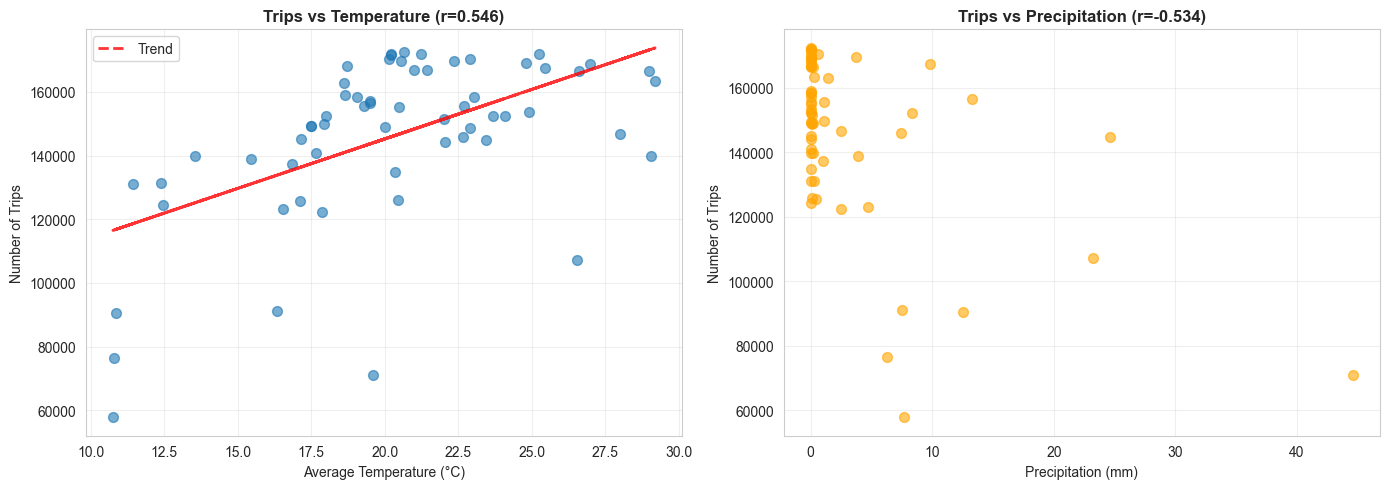

In [7]:
if has_weather:
    # Remove rows with missing weather data
    df_clean = df_weather.drop_nulls(subset=["temp_avg", "precip", "trips_total"])

    # Calculate correlations
    corr_temp = np.corrcoef(df_clean["temp_avg"], df_clean["trips_total"])[0, 1]
    corr_precip = np.corrcoef(df_clean["precip"], df_clean["trips_total"])[0, 1]

    print("=" * 60)
    print("WEATHER CORRELATIONS WITH TRIP DEMAND")
    print("=" * 60)
    print(f"Temperature correlation: {corr_temp:.3f}")
    print(f"Precipitation correlation: {corr_precip:.3f}")

    # Scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Temperature vs Trips
    axes[0].scatter(df_clean["temp_avg"], df_clean["trips_total"], alpha=0.6, s=50)
    axes[0].set_title(f"Trips vs Temperature (r={corr_temp:.3f})", fontsize=12, fontweight="bold")
    axes[0].set_xlabel("Average Temperature (°C)")
    axes[0].set_ylabel("Number of Trips")
    # Add trend line
    z = np.polyfit(df_clean["temp_avg"], df_clean["trips_total"], 1)
    p = np.poly1d(z)
    axes[0].plot(
        df_clean["temp_avg"],
        p(df_clean["temp_avg"]),
        "r--",
        alpha=0.8,
        linewidth=2,
        label="Trend",
    )
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Precipitation vs Trips
    axes[1].scatter(df_clean["precip"], df_clean["trips_total"], alpha=0.6, s=50, color="orange")
    axes[1].set_title(
        f"Trips vs Precipitation (r={corr_precip:.3f})", fontsize=12, fontweight="bold"
    )
    axes[1].set_xlabel("Precipitation (mm)")
    axes[1].set_ylabel("Number of Trips")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠ Weather data not available. Skipping weather impact analysis.")

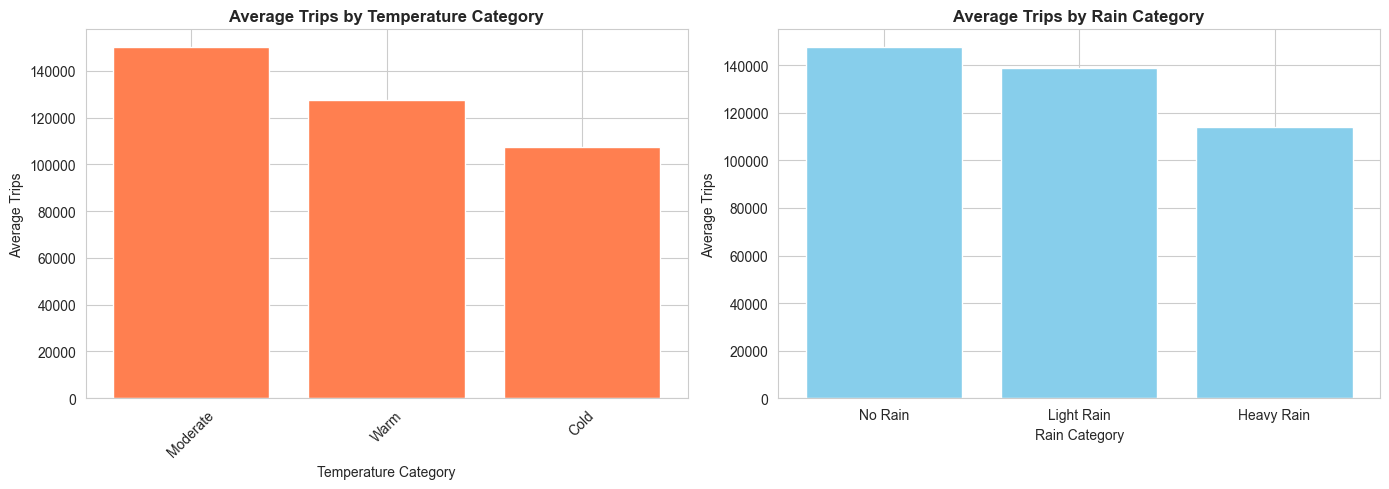


TEMPERATURE CATEGORY IMPACT
shape: (3, 3)
┌───────────────┬───────────────┬──────┐
│ temp_category ┆ avg_trips     ┆ days │
│ ---           ┆ ---           ┆ ---  │
│ str           ┆ f64           ┆ u32  │
╞═══════════════╪═══════════════╪══════╡
│ Moderate      ┆ 150167.977778 ┆ 45   │
│ Warm          ┆ 127646.0      ┆ 11   │
│ Cold          ┆ 107355.857143 ┆ 7    │
└───────────────┴───────────────┴──────┘

RAIN CATEGORY IMPACT
shape: (3, 3)
┌───────────────┬───────────────┬──────┐
│ rain_category ┆ avg_trips     ┆ days │
│ ---           ┆ ---           ┆ ---  │
│ str           ┆ f64           ┆ u32  │
╞═══════════════╪═══════════════╪══════╡
│ No Rain       ┆ 147674.363636 ┆ 33   │
│ Light Rain    ┆ 138795.4      ┆ 25   │
│ Heavy Rain    ┆ 114003.4      ┆ 5    │
└───────────────┴───────────────┴──────┘


In [8]:
if has_weather:
    # Impact by categories
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Temperature category impact
    temp_impact = (
        df_weather.group_by("temp_category")
        .agg(
            [
                pl.col("trips_total").mean().alias("avg_trips"),
                pl.col("trips_total").count().alias("days"),
            ]
        )
        .sort("avg_trips", descending=True)
    )

    axes[0].bar(temp_impact["temp_category"], temp_impact["avg_trips"], color="coral")
    axes[0].set_title("Average Trips by Temperature Category", fontweight="bold")
    axes[0].set_xlabel("Temperature Category")
    axes[0].set_ylabel("Average Trips")
    axes[0].tick_params(axis="x", rotation=45)

    # Rain category impact
    rain_impact = (
        df_weather.group_by("rain_category")
        .agg(
            [
                pl.col("trips_total").mean().alias("avg_trips"),
                pl.col("trips_total").count().alias("days"),
            ]
        )
        .sort("avg_trips", descending=True)
    )

    axes[1].bar(rain_impact["rain_category"], rain_impact["avg_trips"], color="skyblue")
    axes[1].set_title("Average Trips by Rain Category", fontweight="bold")
    axes[1].set_xlabel("Rain Category")
    axes[1].set_ylabel("Average Trips")

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("TEMPERATURE CATEGORY IMPACT")
    print("=" * 60)
    print(temp_impact)

    print("\n" + "=" * 60)
    print("RAIN CATEGORY IMPACT")
    print("=" * 60)
    print(rain_impact)

## 6. Outlier Detection

Identify and analyze outliers in trip data.


OUTLIER DETECTION (IQR Method)
Lower bound: 93968
Upper bound: 209980
Number of outliers: 7 out of 63 days

Outlier days:
shape: (7, 3)
┌───────────────────────────────┬─────────────┬──────────┐
│ ride_date                     ┆ trips_total ┆ day_type │
│ ---                           ┆ ---         ┆ ---      │
│ datetime[μs, Europe/Belgrade] ┆ f64         ┆ str      │
╞═══════════════════════════════╪═════════════╪══════════╡
│ 2024-04-30 00:00:00 CEST      ┆ 9.0         ┆ Weekday  │
│ 2024-07-01 00:00:00 CEST      ┆ 5898.0      ┆ Weekday  │
│ 2024-05-05 00:00:00 CEST      ┆ 57788.0     ┆ Weekend  │
│ 2024-05-27 00:00:00 CEST      ┆ 70906.0     ┆ Weekday  │
│ 2024-05-12 00:00:00 CEST      ┆ 76387.0     ┆ Weekend  │
│ 2024-05-10 00:00:00 CEST      ┆ 90601.0     ┆ Weekday  │
│ 2024-05-15 00:00:00 CEST      ┆ 91088.0     ┆ Weekday  │
└───────────────────────────────┴─────────────┴──────────┘


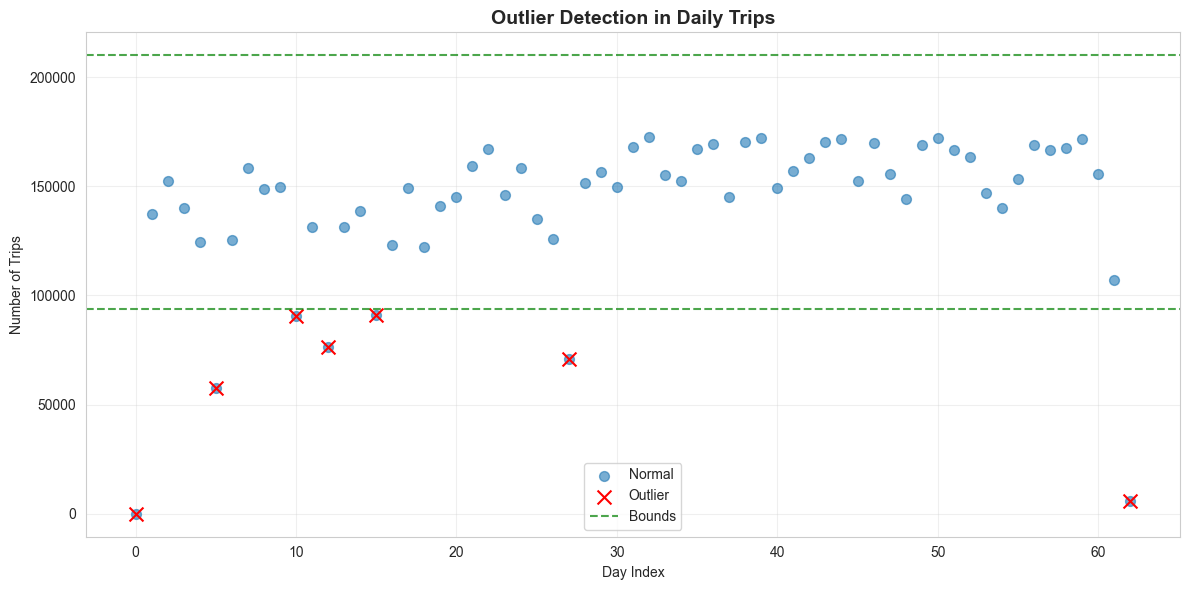

In [9]:
# Detect outliers using IQR method
Q1 = df_demand["trips_total"].quantile(0.25)
Q3 = df_demand["trips_total"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_demand.filter(
    (pl.col("trips_total") < lower_bound) | (pl.col("trips_total") > upper_bound)
)

print("=" * 60)
print("OUTLIER DETECTION (IQR Method)")
print("=" * 60)
print(f"Lower bound: {lower_bound:.0f}")
print(f"Upper bound: {upper_bound:.0f}")
print(f"Number of outliers: {len(outliers)} out of {len(df_demand)} days")

if len(outliers) > 0:
    print("\nOutlier days:")
    print(outliers.select(["ride_date", "trips_total", "day_type"]).sort("trips_total"))

    # Visualize outliers
    plt.figure(figsize=(12, 6))
    plt.scatter(
        range(len(df_demand)),
        df_demand["trips_total"],
        alpha=0.6,
        label="Normal",
        s=50,
    )
    outlier_indices = [
        i
        for i, trip in enumerate(df_demand["trips_total"])
        if trip < lower_bound or trip > upper_bound
    ]
    plt.scatter(
        outlier_indices,
        df_demand[outlier_indices, "trips_total"],
        color="red",
        s=100,
        label="Outlier",
        marker="x",
    )
    plt.axhline(y=lower_bound, color="g", linestyle="--", alpha=0.7, label="Bounds")
    plt.axhline(y=upper_bound, color="g", linestyle="--", alpha=0.7)
    plt.title("Outlier Detection in Daily Trips", fontsize=14, fontweight="bold")
    plt.xlabel("Day Index")
    plt.ylabel("Number of Trips")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("✓ No outliers detected!")

## Summary

Key Findings:
1. Daily trip patterns show clear temporal trends
2. Member and casual riders have different usage patterns
3. Weather significantly impacts bike demand (temperature correlation)
4. Outliers may represent special events or data quality issues

Next Steps:
- Investigate outliers for special events or holidays
- Build predictive models incorporating weather features
- Analyze station-level patterns
- Time-series forecasting for demand planning
